In [ ]:
!pip install datasets
!pip install features

## YAMNet version 1: with dense head (freeze YAMNet) - fast but low performance

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#Load preprocessed dataset & label‑encode
ds = load_dataset("ZZZtong/common-accent-YAMnet")
le = LabelEncoder().fit(ds["train"]["accent"])
ds = ds.map(lambda ex: {"label": int(le.transform([ex["accent"]])[0])})

#Load & freeze YAMNet
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

def extract_emb(wave):
    wave_t = tf.convert_to_tensor(wave, tf.float32)
    _, emb, _ = yamnet(wave_t)
    return tf.reduce_mean(emb, axis=0).numpy()

#build NumPy arrays
def build(split):
    X = np.stack([extract_emb(ex["audio"]["array"]) for ex in ds[split]])
    y = np.array([ex["label"] for ex in ds[split]], dtype=np.int32)
    return X, y

X_train, y_train = build("train")
X_val,   y_val   = build("validation")
X_test,  y_test  = build("test")

#Define & compile model
n_classes   = len(le.classes_)
embed_dim   = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.Input(shape=(embed_dim,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#train model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=2
)

#Evaluate model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.3%}\n")

#predict and show full report
y_pred_probs = model.predict(X_test, verbose=0)
y_pred       = np.argmax(y_pred_probs, axis=1)

print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    digits=4
))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/33.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2538 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/308 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Epoch 1/30
80/80 - 6s - 70ms/step - accuracy: 0.3188 - loss: 1.8372 - val_accuracy: 0.3571 - val_loss: 1.5440
Epoch 2/30
80/80 - 1s - 12ms/step - accuracy: 0.3999 - loss: 1.4960 - val_accuracy: 0.4545 - val_loss: 1.4366
Epoch 3/30
80/80 - 0s - 4ms/step - accuracy: 0.4247 - loss: 1.4358 - val_accuracy: 0.4351 - val_loss: 1.3937
Epoch 4/30
80/80 - 1s - 17ms/step - accuracy: 0.4433 - loss: 1.3939 - val_accuracy: 0.4545 - val_loss: 1.3749
Epoch 5/30
80/80 - 0s - 3ms/step - accuracy: 0.4377 - loss: 1.3869 - val_accuracy: 0.4481 - val_loss: 1.3612
Epoch 6/30
80/80 - 1s - 9ms/step - accuracy: 0.4582 - loss: 1.3624 - val_accuracy: 0.4123 - val_loss: 1.3906
Epoch 7/30
80/80 - 0s - 3ms/step - accuracy: 0.4771 - loss: 1.3191 - val_accuracy: 0.4578 - val_loss: 1.3400
Epoch 8/30
80/80 - 0s - 3ms/step - accuracy: 0.4712 - loss: 1.3207 - val_accuracy: 0.4903 - val_loss: 1.3451
Epoch 9/30
80/80 - 0s - 3ms/step - accuracy: 0.4819 - loss: 1.3073 - val_accuracy: 0.4740 - val_loss: 1.3255
Epoch 10/30
80/8

## YAMNet version 2: fine‑tune YAMNet + custom head (with CPU runtime)

In [ ]:
#Clone TF‑Models
!git clone --depth 1 https://github.com/tensorflow/models.git tf2_models

#download the pretrained YAMNet weights
!wget -q https://storage.googleapis.com/audioset/yamnet.h5

Cloning into 'tf2_models'...
remote: Enumerating objects: 4327, done.
remote: Counting objects: 100% (4327/4327), done.
remote: Compressing objects: 100% (3345/3345), done.
remote: Total 4327 (delta 1208), reused 2049 (delta 910), pack-reused 0 (from 0)
Receiving objects: 100% (4327/4327), 53.65 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.
Updating files: 100% (3900/3900), done.


In [ ]:
import tensorflow as tf
import importlib.util
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import time
import sys, importlib.util, tensorflow as tf

#timing setup
timing_results = {}
def record_time(label, func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    timing_results[label] = end - start
    return result

BASE = "tf2_models/research/audioset/yamnet"

if BASE not in sys.path:
    sys.path.insert(0, BASE)

def load_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[name] = mod
    return mod

features_lib = load_module("features", f"{BASE}/features.py")

#load params.py and yamnet.py
params_mod  = load_module("yamnet_params", f"{BASE}/params.py")
yamnet_impl = load_module("yamnet_impl",  f"{BASE}/yamnet.py")

#build model
params        = params_mod.Params()
frames_model  = yamnet_impl.yamnet_frames_model(params)
frames_model.load_weights("yamnet.h5")
frames_model.trainable = True

print("YAMNet frames model built.  Layers:", len(frames_model.layers))

YAMNet frames model built.  Layers: 106


In [ ]:
#Wrap as a trainable Keras Layer (fixed)
class YamNetBackbone(tf.keras.layers.Layer):
    def __init__(self, yamnet_model, **kwargs):
        super().__init__(name="yamnet_backbone", **kwargs)
        self.yamnet = yamnet_model

    def call(self, wave_batch):
        return tf.vectorized_map(lambda w: self.yamnet(w)[1], wave_batch)

yamnet_backbone = YamNetBackbone(frames_model)

In [ ]:
ds = record_time("load_dataset", load_dataset, "ZZZtong/common-accent-YAMnet")
le = LabelEncoder().fit(ds["train"]["accent"])
ds = ds.map(lambda ex: {"label": int(le.transform([ex["accent"]])[0])})

def make_ds(split, batch_size=16):
    def gen():
        for ex in ds[split]:
            yield ex["audio"]["array"].astype(np.float32), ex["label"]
    sig = (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
    return (
        tf.data.Dataset
        .from_generator(gen, output_signature=sig)
        .shuffle(1000)
        .padded_batch(batch_size, padded_shapes=([None], []))
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = record_time("make_train_ds", make_ds, "train", batch_size=16)
val_ds   = record_time("make_val_ds",   make_ds, "validation", batch_size=16)
test_ds  = record_time("make_test_ds",  make_ds, "test", batch_size=16)

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
import math

num_classes = len(le.classes_)

#input: raw waveform
wave_input = tf.keras.Input(shape=(None,), dtype=tf.float32, name="waveform")

#backbone → embeddings sequence
emb_seq = yamnet_backbone(wave_input)

#pool → head → softmax
x = tf.keras.layers.GlobalAveragePooling1D()(emb_seq)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_ft = tf.keras.Model(inputs=wave_input, outputs=output)


BATCH = 16
steps_per_epoch = math.ceil(len(ds["train"]) / BATCH)
decayed_lr = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=steps_per_epoch * 5,           #5 planned epochs
    alpha=0.1
)
opt_head = AdamW(learning_rate=decayed_lr, weight_decay=1e-4)

model_ft.compile(
    optimizer=opt_head,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(model_ft.summary())

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ waveform (InputLayer)           │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ yamnet_backbone                 │ (None, None, 1024)     │             0 │
│ (YamNetBackbone)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,974 (515.52 KB)

 Trainable params: 131,974 (515.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#head training
history_head = record_time("train_head",
    model_ft.fit,
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=2,
)

Epoch 1/5
159/159 - 180s - 1s/step - accuracy: 0.3010 - loss: 1.7504 - val_accuracy: 0.4156 - val_loss: 1.5391
Epoch 2/5
159/159 - 201s - 1s/step - accuracy: 0.3700 - loss: 1.5506 - val_accuracy: 0.3994 - val_loss: 1.4795
Epoch 3/5
159/159 - 151s - 953ms/step - accuracy: 0.3901 - loss: 1.4861 - val_accuracy: 0.3994 - val_loss: 1.4583
Epoch 4/5
159/159 - 202s - 1s/step - accuracy: 0.4102 - loss: 1.4474 - val_accuracy: 0.4318 - val_loss: 1.4128
Epoch 5/5
159/159 - 202s - 1s/step - accuracy: 0.4480 - loss: 1.4097 - val_accuracy: 0.4351 - val_loss: 1.3776


In [ ]:
#unfreeze the yamnet_backbone layer
model_ft.get_layer("yamnet_backbone").trainable = True

decayed_lr_ft = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=steps_per_epoch * 6,
    alpha=0.1
)
opt_ft = AdamW(learning_rate=decayed_lr_ft, weight_decay=1e-4)

#re‑compile with a lower LR for the backbone
model_ft.compile(
    optimizer=opt_ft,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#fine‑tune for a few more epochs
history_ft = record_time("fine_tune",
    model_ft.fit,
    train_ds,
    validation_data=val_ds,
    epochs=6,
    verbose=2,
)

Epoch 1/6
159/159 - 222s - 1s/step - accuracy: 0.4507 - loss: 1.3744 - val_accuracy: 0.4545 - val_loss: 1.3645
Epoch 2/6
159/159 - 169s - 1s/step - accuracy: 0.4559 - loss: 1.3634 - val_accuracy: 0.4545 - val_loss: 1.3643
Epoch 3/6
159/159 - 154s - 970ms/step - accuracy: 0.4543 - loss: 1.3664 - val_accuracy: 0.4578 - val_loss: 1.3618
Epoch 4/6
159/159 - 262s - 2s/step - accuracy: 0.4590 - loss: 1.3663 - val_accuracy: 0.4513 - val_loss: 1.3595
Epoch 5/6
159/159 - 202s - 1s/step - accuracy: 0.4649 - loss: 1.3629 - val_accuracy: 0.4610 - val_loss: 1.3593
Epoch 6/6
159/159 - 159s - 1s/step - accuracy: 0.4649 - loss: 1.3661 - val_accuracy: 0.4578 - val_loss: 1.3586


In [ ]:
#evaluate overall accuracy
loss, acc = record_time("evaluate", model_ft.evaluate, test_ds, verbose=0)
print(f"\nTest accuracy: {acc:.3%}\n")

#classification_report
y_true, y_pred = [], []
for Xb, yb in test_ds:
    probs = model_ft.predict(Xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(yb.numpy())

print(record_time("classification_report", classification_report,
    y_true, y_pred, target_names=le.classes_, digits=4
))

print("Timing Summary:")
for k, v in timing_results.items():
    print(f"{k:<20} — {v:.2f} sec")


Test accuracy: 49.515%

                                                    precision    recall  f1-score   support

                                          Filipino     0.5217    0.2791    0.3636        43
                 German English,Non native speaker     0.5106    0.9796    0.6713        49
                                 Hong Kong English     0.5556    0.2128    0.3077        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.4630    0.5882    0.5181        85
                               Singaporean English     0.6667    0.1579    0.2553        38
Southern African (South Africa, Zimbabwe, Namibia)     0.4737    0.5745    0.5192        47

                                          accuracy                         0.4951       309
                                         macro avg     0.5319    0.4653    0.4392       309
                                      weighted avg     0.5195    0.4951    0.4568       309

Timing Summary:
load_dataset         — 23.56 sec
mak

In [ ]:
#save time records
from google.colab import drive
drive.mount('/content/drive')

import json
with open('/content/drive/MyDrive/timing_results.json', 'w') as f:
    json.dump(timing_results, f)

Mounted at /content/drive


## YAMNet version 3: fine‑tune YAMNet + custom head + with cached embeddings to speed up (with GPU)

In [ ]:
#clone TF‑Models under a new folder so it doesn’t collide with your own `models/`
!git clone --depth 1 https://github.com/tensorflow/models.git tf2_models

#download the pretrained YAMNet weights
!wget -q https://storage.googleapis.com/audioset/yamnet.h5

Cloning into 'tf2_models'...
remote: Enumerating objects: 4327, done.
remote: Counting objects: 100% (4327/4327), done.
remote: Compressing objects: 100% (3346/3346), done.
remote: Total 4327 (delta 1208), reused 2046 (delta 909), pack-reused 0 (from 0)
Receiving objects: 100% (4327/4327), 53.65 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


In [ ]:
import importlib.util
import tensorflow as tf
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import sys, importlib.util, tensorflow as tf
import time

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("TensorFlow sees the following GPU(s):")
    for i, g in enumerate(gpus):
        print(f"  [{i}] {g}")
else:
    print("No GPU detected — running on CPU only.")

#make sure running on GPU
@tf.function
def dummy(x):
    return x * 2.0
t = tf.random.uniform((8, 1024))
res = dummy(t)
print("Dummy tensor is on:", res.device)


#trace running time
timing_results_cached = {}

def record_time_cached(label, func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    timing_results_cached[label] = end - start
    return result


BASE = "tf2_models/research/audioset/yamnet"

if BASE not in sys.path:
    sys.path.insert(0, BASE)

def load_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[name] = mod       # insure later imports hit this one
    return mod

features_lib = load_module("features", f"{BASE}/features.py")

#load params.py and yamnet.py
params_mod  = load_module("yamnet_params", f"{BASE}/params.py")
yamnet_impl = load_module("yamnet_impl",  f"{BASE}/yamnet.py")

#build model
params        = params_mod.Params()
frames_model  = yamnet_impl.yamnet_frames_model(params)
frames_model.load_weights("yamnet.h5")
frames_model.trainable = True

print("YAMNet frames model built.  Layers:", len(frames_model.layers))

TensorFlow sees the following GPU(s):
  [0] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Dummy tensor is on: /job:localhost/replica:0/task:0/device:GPU:0
YAMNet frames model built.  Layers: 106


In [ ]:
import tensorflow as tf

class YamNetBackbone(tf.keras.layers.Layer):
    def __init__(self, frames_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet = frames_model

    def call(self, wave_batch):
        #wav_batch: (B, T)
        embeddings = tf.map_fn(
            lambda w: self.yamnet(w)[1],                          #call on each 1-D waveform
            wave_batch,
            fn_output_signature=tf.TensorSpec((None, 1024), tf.float32)
        )
        #embeddings: (B, frames, 1024)
        return embeddings
yamnet_backbone = YamNetBackbone(frames_model)

In [ ]:
#load and encode labels
ds = record_time_cached("load_dataset", load_dataset, "ZZZtong/common-accent-YAMnet")
le = LabelEncoder().fit(ds["train"]["accent"])
ds = ds.map(lambda ex: {"label": int(le.transform([ex["accent"]])[0])})

#build tf.data pipelines
def make_ds(split, batch_size=16):
    def gen():
        for ex in ds[split]:
            #waveform array + label
            yield ex["audio"]["array"].astype(np.float32), ex["label"]

    sig = (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(),      dtype=tf.int32),
    )
    return (
        tf.data.Dataset
        .from_generator(gen, output_signature=sig)
        .shuffle(1000)
        .padded_batch(batch_size, padded_shapes=([None], []))
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = record_time_cached("make_train_ds", make_ds, "train", batch_size=16)
val_ds = record_time_cached("make_val_ds", make_ds, "validation", batch_size=16)
test_ds = record_time_cached("make_test_ds", make_ds, "test", batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/33.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2538 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/308 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/2538 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import time

@tf.function(jit_compile=True)
def waveform_to_emb(wav_batch):
    """
    wav_batch: (B, T) float32
    returns:   (B, frames, 1024) float32 embeddings
    """
    #map each example through the 1-D-only frames model
    embeddings = tf.map_fn(
        lambda w: frames_model(w)[1],
        wav_batch,
        fn_output_signature=tf.TensorSpec((None, 1024), tf.float32)
    )
    return embeddings

#precompute + pool
def precompute_embeddings(ds):
    X_chunks, y_chunks = [], []
    for wav_batch, label_batch in tqdm(ds, desc="Embedding batches"):
        #emb_batch: (B, frames, 1024)
        emb_batch = waveform_to_emb(wav_batch)
        #pool time → (B, 1024)
        pooled    = tf.reduce_mean(emb_batch, axis=1)
        X_chunks.append(pooled.numpy())
        y_chunks.append(label_batch.numpy())
    X = np.concatenate(X_chunks, axis=0)
    y = np.concatenate(y_chunks, axis=0)
    return X, y

X_train, y_train = precompute_embeddings(train_ds_fast)
X_val,   y_val   = precompute_embeddings(val_ds_fast)
X_test,  y_test  = precompute_embeddings(test_ds_fast)

t0 = time.time()
X_train, y_train = precompute_embeddings(train_ds_fast)
timing_results_cached['embed_train'] = time.time() - t0

t0 = time.time()
X_val, y_val = precompute_embeddings(val_ds_fast)
timing_results_cached['embed_val'] = time.time() - t0

t0 = time.time()
X_test, y_test = precompute_embeddings(test_ds_fast)
timing_results_cached['embed_test'] = time.time() - t0

Embedding batches: 318it [00:12, 25.20it/s]
Embedding batches: 39it [00:01, 20.36it/s]
Embedding batches: 39it [00:01, 21.43it/s]
Embedding batches: 318it [00:09, 32.27it/s]
Embedding batches: 39it [00:01, 35.46it/s]
Embedding batches: 39it [00:01, 33.45it/s]


In [ ]:
#with early stop, no decay

#import tensorflow as tf
#from tensorflow.keras.callbacks import EarlyStopping

#num_classes = len(le.classes_)

#head = tf.keras.Sequential([
#    tf.keras.layers.Input(shape=(1024,)),
#    tf.keras.layers.Dense(256, activation="relu"),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(num_classes, activation="softmax"),
#])

#opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

#head.compile(optimizer=opt,
#             loss="sparse_categorical_crossentropy",
#             metrics=["accuracy"])

#record_time_cached(
#    "train_head",
#    head.fit,
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=60,
#    batch_size=32,
#    verbose=2,
#    callbacks=[EarlyStopping(monitor="val_accuracy",
#                             patience=5,
#                             restore_best_weights=True)]
#)

#print("\nTest acc on embeddings:",
#      head.evaluate(X_test, y_test, verbose=0)[1])

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

num_classes = len(le.classes_)

head = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

decayed_lr = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=len(X_train) // 32 * 40,   #40 epochs × steps/epoch
    alpha=0.1
)

opt = AdamW(learning_rate=decayed_lr, weight_decay=1e-4)

head.compile(optimizer=opt,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

record_time_cached(
    "train_head",
    head.fit,
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    verbose=2,
)

print("\nTest acc on embeddings:",
      head.evaluate(X_test, y_test, verbose=0)[1])

Epoch 1/40
80/80 - 4s - 50ms/step - accuracy: 0.3077 - loss: 1.7589 - val_accuracy: 0.3117 - val_loss: 1.5734
Epoch 2/40
80/80 - 0s - 4ms/step - accuracy: 0.3727 - loss: 1.5408 - val_accuracy: 0.4156 - val_loss: 1.5024
Epoch 3/40
80/80 - 0s - 3ms/step - accuracy: 0.3940 - loss: 1.5016 - val_accuracy: 0.3994 - val_loss: 1.4549
Epoch 4/40
80/80 - 0s - 3ms/step - accuracy: 0.4125 - loss: 1.4690 - val_accuracy: 0.3994 - val_loss: 1.4348
Epoch 5/40
80/80 - 0s - 3ms/step - accuracy: 0.4145 - loss: 1.4549 - val_accuracy: 0.4188 - val_loss: 1.4312
Epoch 6/40
80/80 - 0s - 3ms/step - accuracy: 0.4267 - loss: 1.4369 - val_accuracy: 0.4091 - val_loss: 1.4096
Epoch 7/40
80/80 - 0s - 4ms/step - accuracy: 0.4291 - loss: 1.4104 - val_accuracy: 0.4058 - val_loss: 1.4117
Epoch 8/40
80/80 - 0s - 4ms/step - accuracy: 0.4184 - loss: 1.4156 - val_accuracy: 0.4253 - val_loss: 1.3851
Epoch 9/40
80/80 - 0s - 3ms/step - accuracy: 0.4338 - loss: 1.4064 - val_accuracy: 0.4513 - val_loss: 1.3917
Epoch 10/40
80/80 

In [ ]:
#build full waveform model
import math

wave_in  = tf.keras.Input(shape=(None,), dtype=tf.float32, name="waveform")
emb_seq  = yamnet_backbone(wave_in)
x = tf.keras.layers.GlobalAveragePooling1D()(emb_seq)

dense_256 = tf.keras.layers.Dense(128, activation="relu", name="dense_256")(x)
dropout   = tf.keras.layers.Dropout(0.5, name="dropout")(dense_256)
output    = tf.keras.layers.Dense(num_classes, activation="softmax",
                                  name="dense_out")(dropout)

full_model = tf.keras.Model(wave_in, output, name="full_yamnet_model")

#locate the Dense(256) and Dense(num_classes) layers
def find_dense(model, units):
    return next(l for l in model.layers
                if isinstance(l, tf.keras.layers.Dense) and l.units == units)

full_dense_256  = find_dense(full_model, 128)
full_dense_out  = find_dense(full_model, num_classes)

head_dense_256  = find_dense(head, 128)
head_dense_out  = find_dense(head, num_classes)

full_dense_256.set_weights(head_dense_256.get_weights())
full_dense_out.set_weights(head_dense_out.get_weights())

print("head weights copied into waveform model")

#unfreeze backbone for fine‑tuning ──
full_model.get_layer("yam_net_backbone").trainable = True


BATCH = 16                               # your batch size for train_ds
steps_per_epoch_ft = math.ceil(len(ds["train"]) / BATCH)


decayed_lr_ft = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=steps_per_epoch_ft * 6,
    alpha=0.1                            # final LR = 0.1 × initial
)
opt_ft = AdamW(learning_rate=decayed_lr_ft, weight_decay=1e-4)

#compile with a lower LR
full_model.compile(
    optimizer=opt_ft,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

head weights copied into waveform model


In [ ]:
record_time_cached("fine_tune",
                   full_model.fit,
                   train_ds,
                   validation_data=val_ds,
                   epochs=6,
                   verbose=2,
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                       patience=2, restore_best_weights=True)])

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


159/159 - 83s - 524ms/step - accuracy: 0.5634 - loss: 1.1253 - val_accuracy: 0.5552 - val_loss: 1.1736
Epoch 2/6
159/159 - 17s - 107ms/step - accuracy: 0.5678 - loss: 1.1226 - val_accuracy: 0.5552 - val_loss: 1.1728
Epoch 3/6
159/159 - 21s - 132ms/step - accuracy: 0.5729 - loss: 1.1195 - val_accuracy: 0.5584 - val_loss: 1.1738
Epoch 4/6
159/159 - 20s - 127ms/step - accuracy: 0.5768 - loss: 1.1128 - val_accuracy: 0.5584 - val_loss: 1.1732


In [ ]:
loss, acc = full_model.evaluate(test_ds, verbose=0)
print(f"\n Final test accuracy: {acc:.3%}\n")

y_true, y_pred = [], []
for wav_b, lab_b in test_ds:
    y_pred.extend(np.argmax(full_model.predict(wav_b, verbose=0), axis=1))
    y_true.extend(lab_b.numpy())

print(classification_report(y_true, y_pred,
                            target_names=le.classes_, digits=4))


 Final test accuracy: 55.663%

                                                    precision    recall  f1-score   support

                                          Filipino     0.4412    0.3488    0.3896        43
                 German English,Non native speaker     0.6351    0.9592    0.7642        49
                                 Hong Kong English     0.7917    0.4043    0.5352        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.5048    0.6235    0.5579        85
                               Singaporean English     0.7692    0.2632    0.3922        38
Southern African (South Africa, Zimbabwe, Namibia)     0.4746    0.5957    0.5283        47

                                          accuracy                         0.5566       309
                                         macro avg     0.6028    0.5325    0.5279       309
                                      weighted avg     0.5882    0.5566    0.5389       309



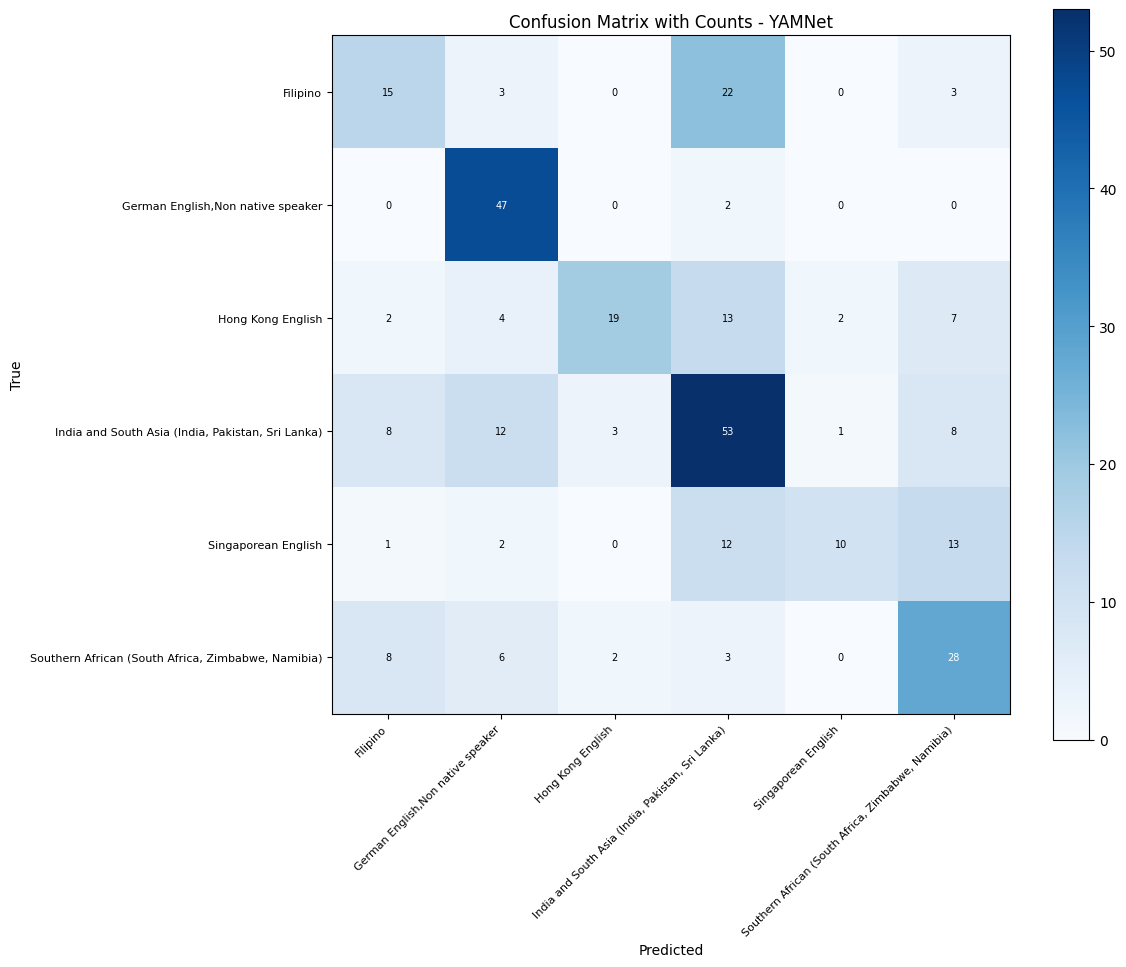

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume y_true, y_pred, and le.classes_ already defined
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
fig.colorbar(im, ax=ax)

# Tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(labels, rotation=0, fontsize=8)

# Annotate each cell with the numeric value
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black',
            fontsize=7
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix with Counts - YAMNet")
plt.tight_layout()
plt.show()


## Running time comparison for v2 and v3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                 Step  V1_time_s  V2_time_s Speedup (%)
classification_report       0.02       0.00     100.0 %
           embed_test       0.00       1.17          --
          embed_train       0.00       9.87          --
            embed_val       0.00       1.10          --
       embedding_pass       0.00      31.34          --
             evaluate      18.34       0.00     100.0 %
            fine_tune    1168.09     146.51      87.5 %
         load_dataset      23.56      13.92      40.9 %
         make_test_ds       0.05       0.12    -156.3 %
        make_train_ds       0.09       0.28    -209.0 %
          make_val_ds       0.05       0.14    -157.2 %
           train_head     936.69      16.18      98.3 %
                TOTAL    2146.89     220.62      89.7 %


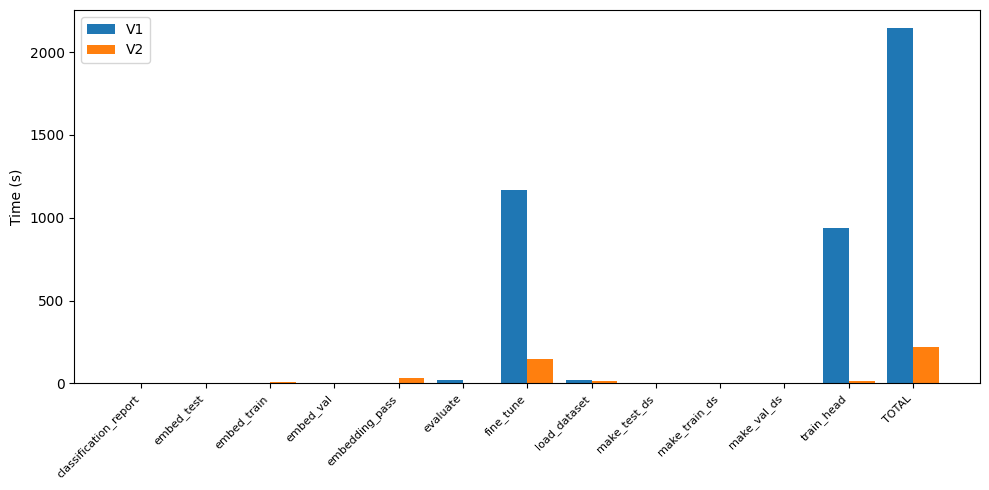

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
with open('/content/drive/MyDrive/timing_results.json', 'r') as f:
    timing_v1 = json.load(f)

timing_v2 = timing_results_cached


all_steps = sorted(set(timing_v1) | set(timing_v2))
records = []
for step in all_steps:
    t1 = timing_v1.get(step, 0)
    t2 = timing_v2.get(step, 0)
    speed = 100 * (t1 - t2) / t1 if t1 else None
    records.append({
        "Step": step,
        "V1_time_s": round(t1, 2),
        "V2_time_s": round(t2, 2),
        "Speedup (%)": f"{speed:.1f} %" if speed is not None else "--"
    })

total1 = sum(timing_v1.get(s, 0) for s in all_steps)
total2 = sum(timing_v2.get(s, 0) for s in all_steps)
total_speed = 100 * (total1 - total2) / total1 if total1 else None
records.append({
    "Step": "TOTAL",
    "V1_time_s": round(total1, 2),
    "V2_time_s": round(total2, 2),
    "Speedup (%)": f"{total_speed:.1f} %" if total_speed is not None else "--"
})

df = pd.DataFrame(records)
print(df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(df))
width = 0.4
ax.bar([i - width/2 for i in x], df["V1_time_s"], width, label="V1")
ax.bar([i + width/2 for i in x], df["V2_time_s"], width, label="V2")
ax.set_xticks(x)
ax.set_xticklabels(df["Step"], rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Time (s)")
ax.legend()
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      Step    V1_s   V2_s Speed_up_pct
train_head  936.69  16.18       98.3 %
 fine_tune 1168.09 146.51       87.5 %
     TOTAL 2104.78 162.69       92.3 %


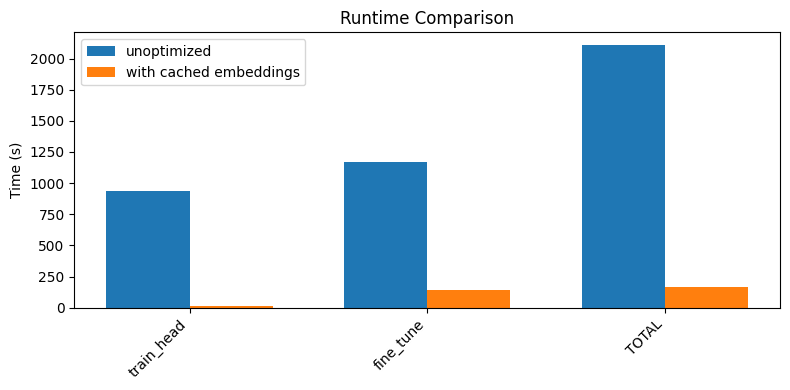

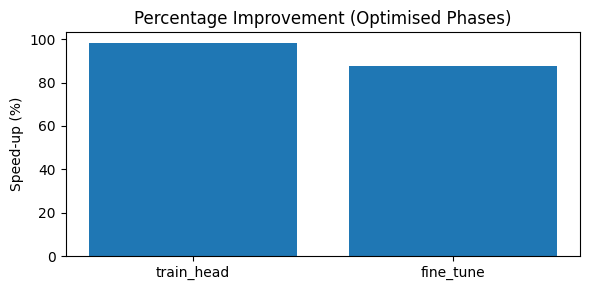

12.139338493347168


In [ ]:
#make graph with only certain steps
import pandas as pd
import matplotlib.pyplot as plt

#Later—reload
from google.colab import drive
drive.mount('/content/drive')
import json
with open('/content/drive/MyDrive/timing_results.json', 'r') as f:
    timing_results = json.load(f)
steps = ["embed_train", "train_head", "fine_tune"]


embed_steps = ["embed_train", "embed_val", "embed_test"]
embed_v2 = sum(timing_results_cached.get(s, 0) for s in embed_steps)

steps = [
    ("train_head",     timing_results.get("train_head", 0),
                      timing_results_cached.get("train_head", 0)),
    ("fine_tune",      timing_results.get("fine_tune", 0),
                      timing_results_cached.get("fine_tune", 0)),
]

df = (pd.DataFrame(steps, columns=["Step", "V1_s", "V2_s"])
        .assign(Speed_up_pct=lambda d: 100*(d["V1_s"]-d["V2_s"])/d["V1_s"].replace(0, pd.NA))
        .round(2))

df.loc[len(df)] = ["TOTAL",
                   df["V1_s"].sum(),
                   df["V2_s"].sum(),
                   100*(df["V1_s"].sum() - df["V2_s"].sum())/df["V1_s"].sum()]

print(df.to_string(index=False, formatters={"Speed_up_pct":
                                           lambda x: f"{x:.1f} %" if pd.notna(x) else "--"}))

fig, ax = plt.subplots(figsize=(8,4))
w = 0.35
x = range(len(df))
ax.bar([i-w/2 for i in x], df["V1_s"], width=w, label="unoptimized")
ax.bar([i+w/2 for i in x], df["V2_s"], width=w, label="with cached embeddings")
ax.set_xticks(x)
ax.set_xticklabels(df["Step"], rotation=45, ha="right")
ax.set_ylabel("Time (s)")
ax.set_title("Runtime Comparison")
ax.legend(); plt.tight_layout(); plt.show()


fig, ax = plt.subplots(figsize=(6,3))
df_no_total = df[df["Step"]!="TOTAL"]
ax.bar(df_no_total["Step"], df_no_total["Speed_up_pct"])
ax.set_ylabel("Speed-up (%)")
ax.set_title("Percentage Improvement (Optimised Phases)")
plt.tight_layout(); plt.show()

print(embed_v2)

## YAMNet version 4: fine‑tune YAMNet + custom head + with cached embeddings + further optimization

In [ ]:
#clone TF‑Models under a new folder so it doesn’t collide with your own `models/`
!git clone --depth 1 https://github.com/tensorflow/models.git tf2_models

#download the pretrained YAMNet weights
!wget -q https://storage.googleapis.com/audioset/yamnet.h5

Cloning into 'tf2_models'...
remote: Enumerating objects: 4327, done.
remote: Counting objects: 100% (4327/4327), done.
remote: Compressing objects: 100% (3346/3346), done.
remote: Total 4327 (delta 1208), reused 2046 (delta 909), pack-reused 0 (from 0)
Receiving objects: 100% (4327/4327), 53.65 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


In [ ]:
import importlib.util
import sys
import time
import os
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
import math

#advanced optimization imports
from numba import jit, prange, cuda
from concurrent.futures import ThreadPoolExecutor

# =====================================================================
# Performance Tracking System
# =====================================================================

class TimingTracker:
    def __init__(self):
        self.results = {}
        self.start_times = {}
        self.original_results = {}

    def start(self, label):
        """Start timing an operation"""
        self.start_times[label] = time.time()

    def end(self, label):
        """End timing an operation and record result"""
        if label in self.start_times:
            self.results[label] = time.time() - self.start_times[label]
            del self.start_times[label]
            return self.results[label]
        return None

    def record(self, label, func, *args, **kwargs):
        """Time a function execution"""
        self.start(label)
        result = func(*args, **kwargs)
        self.end(label)
        return result

    def import_original_timings(self, timing_dict):
        """Import original timing results for comparison"""
        self.original_results = timing_dict

    def report(self):
        """Generate a performance report comparing original and optimized times"""
        print("\n--- Performance Comparison ---")
        print(f"{'Operation':<25} {'Original (s)':<15} {'Optimized (s)':<15} {'Speedup':<10}")
        print("-" * 70)

        #compare timings
        for key in set(list(self.original_results.keys()) + list(self.results.keys())):
            orig = self.original_results.get(key, float('nan'))
            opt = self.results.get(key, float('nan'))

            if np.isnan(orig):
                print(f"{key:<25} {'N/A':<15} {opt:<15.3f} {'N/A':<10}")
            elif np.isnan(opt):
                print(f"{key:<25} {orig:<15.3f} {'N/A':<15} {'N/A':<10}")
            else:
                speedup = orig / opt if opt > 0 else float('inf')
                print(f"{key:<25} {orig:<15.3f} {opt:<15.3f} {speedup:<10.2f}x")
timer = TimingTracker()
timing_results_cached = {}  #original timing dictionary for comparison

# =====================================================================
# GPU Configuration and Optimization
# =====================================================================

#configure GPU memory growth to avoid memory allocation issues
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("TensorFlow sees the following GPU(s):")
    for i, g in enumerate(gpus):
        print(f"  [{i}] {g}")
        #enable memory growth to avoid allocating all GPU memory at once
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except RuntimeError as e:
            print(f"Error setting memory growth: {e}")

    #set TensorFlow to use mixed precision for faster computation on compatible GPUs
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f"Compute dtype: {policy.compute_dtype}")
    print(f"Variable dtype: {policy.variable_dtype}")
else:
    print("No GPU detected — running on CPU only.")

#check if CUDA is available for Numba
CUDA_AVAILABLE = False
try:
    CUDA_AVAILABLE = cuda.is_available()
    if CUDA_AVAILABLE:
        print("CUDA is available for Numba acceleration")
        #test CUDA with a simple kernel to verify compatibility
        @cuda.jit
        def test_kernel(x, y):
            i = cuda.grid(1)
            if i < x.size:
                y[i] = x[i] * 2

        try:
            #create small test arrays
            x = np.array([1, 2, 3, 4, 5], dtype=np.float32)
            y = np.zeros_like(x)

            #configure small grid
            threads_per_block = 32
            blocks_per_grid = (x.size + threads_per_block - 1) // threads_per_block

            test_kernel[blocks_per_grid, threads_per_block](x, y)
            cuda.synchronize()

            print("CUDA test successful, GPU acceleration enabled")
        except Exception as e:
            print(f"CUDA test failed with error: {e}")
            print("Falling back to Numba CPU acceleration")
            CUDA_AVAILABLE = False
except Exception as e:
    print(f"Numba CUDA not available: {e}")
    CUDA_AVAILABLE = False

if not CUDA_AVAILABLE:
    print("CUDA acceleration disabled, using CPU-only optimizations")

#verify GPU is working
@tf.function(jit_compile=True)  #XLA compilation for faster execution
def dummy(x):
    return x * 2.0

t = tf.random.uniform((8, 1024))
res = dummy(t)
print("Dummy tensor is on:", res.device)

# =====================================================================
# Numba Optimized Functions
# =====================================================================

@jit(nopython=True, parallel=True)
def numba_mean_pooling(embeddings):
    """
    Parallel mean pooling using Numba
    Takes a 2D array (frames, features) and returns mean across frames for each feature
    """
    result = np.zeros(embeddings.shape[1], dtype=np.float32)
    for i in prange(embeddings.shape[1]):
        result[i] = np.mean(embeddings[:, i])
    return result

#CUDA kernel for mean pooling if available
if CUDA_AVAILABLE:
    @cuda.jit
    def cuda_mean_kernel(embeddings, result, n_frames):
        """CUDA kernel for mean pooling"""
        feat_idx = cuda.grid(1)
        if feat_idx < embeddings.shape[1]:
            sum_val = 0.0
            for i in range(n_frames):
                sum_val += embeddings[i, feat_idx]
            result[feat_idx] = sum_val / n_frames

    def cuda_mean_pooling(embeddings):
        """Mean pooling using CUDA"""
        n_frames, n_features = embeddings.shape
        result = np.zeros(n_features, dtype=np.float32)

        #configure CUDA grid
        threads_per_block = 128
        blocks_per_grid = (n_features + threads_per_block - 1) // threads_per_block

        d_embeddings = cuda.to_device(embeddings)
        d_result = cuda.to_device(result)

        cuda_mean_kernel[blocks_per_grid, threads_per_block](d_embeddings, d_result, n_frames)
        return d_result.copy_to_host()

# =====================================================================
# Load YAMNet model
# =====================================================================

BASE = "tf2_models/research/audioset/yamnet"

if BASE not in sys.path:
    sys.path.insert(0, BASE)

def load_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    sys.modules[name] = mod  #ensure later imports hit this one
    return mod

timer.start("load_modules")
features_lib = load_module("features", f"{BASE}/features.py")
params_mod = load_module("yamnet_params", f"{BASE}/params.py")
yamnet_impl = load_module("yamnet_impl", f"{BASE}/yamnet.py")
timer.end("load_modules")

#build YAMNet model
timer.start("build_yamnet")
params = params_mod.Params()
frames_model = yamnet_impl.yamnet_frames_model(params)
frames_model.load_weights("yamnet.h5")
frames_model.trainable = True
timer.end("build_yamnet")

print("YAMNet frames model built. Layers:", len(frames_model.layers))

# =====================================================================
# YAMNet Backbone Layer with XLA Optimization
# =====================================================================

class YamNetBackbone(tf.keras.layers.Layer):
    def __init__(self, frames_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet = frames_model

    @tf.function(jit_compile=True)  #enable XLA compilation for speedup
    def call(self, wave_batch):
        # wav_batch: (B, T)
        embeddings = tf.map_fn(
            lambda w: self.yamnet(w)[1],  #call on each 1-D waveform
            wave_batch,
            fn_output_signature=tf.TensorSpec((None, 1024), tf.float32),
            parallel_iterations=24  #increase parallel iterations for better GPU utilization
        )
        #embeddings: (B, frames, 1024)
        return embeddings

yamnet_backbone = YamNetBackbone(frames_model)

# =====================================================================
# Dataset Loading
# =====================================================================

print("Loading dataset...")
timer.start("load_dataset")
ds = load_dataset("ZZZtong/common-accent-YAMnet")
timer.end("load_dataset")

#fit label encoder and print classes
le = LabelEncoder().fit(ds["train"]["accent"])
num_classes = len(le.classes_)
print(f"Number of accent classes: {num_classes}")
print(f"Classes: {le.classes_}")

#apply label encoding in a single pass
def encode_labels(example):
    """Encode labels for a single example"""
    example["label"] = int(le.transform([example["accent"]])[0])
    return example

#apply encoding to all datasets
timer.start("encode_labels")
ds_encoded = {
    "train": ds["train"].map(encode_labels),
    "validation": ds["validation"].map(encode_labels),
    "test": ds["test"].map(encode_labels)
}
timer.end("encode_labels")

# =====================================================================
# Optimized tf.data Pipeline with Caching
# =====================================================================

#create cache directory if it doesn't exist
cache_dir = "./tf_data_cache"
os.makedirs(cache_dir, exist_ok=True)

def make_optimized_ds(split, batch_size=16, cache=True):
    """Create an optimized tf.data pipeline with caching and prefetching"""
    cache_path = f"{cache_dir}/{split}.tfcache" if cache else None

    def gen():
        for ex in ds_encoded[split]:
            #waveform array + label
            yield ex["audio"]["array"].astype(np.float32), ex["label"]

    sig = (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )

    #build optimized pipeline
    dataset = tf.data.Dataset.from_generator(gen, output_signature=sig)

    #cache the dataset for faster processing
    if cache:
        try:
            #try in-memory caching first
            dataset = dataset.cache()
        except:
            #fall back to disk caching if memory is insufficient
            dataset = dataset.cache(cache_path)

    #apply optimization options (using non-deprecated API)
    options = tf.data.Options()
    options.deterministic = False
    options.experimental_optimization.parallel_batch = True
    options.experimental_optimization.map_parallelization = True
    options.threading.max_intra_op_parallelism = 4
    options.threading.private_threadpool_size = 4

    return (
        dataset.with_options(options)
        .shuffle(buffer_size=min(1000, len(ds_encoded[split])))
        .padded_batch(batch_size, padded_shapes=([None], []))
        .prefetch(tf.data.AUTOTUNE)
    )

print("Creating optimized datasets...")
timer.start("make_train_ds")
train_ds = make_optimized_ds("train", batch_size=16)
timer.end("make_train_ds")

timer.start("make_val_ds")
val_ds = make_optimized_ds("validation", batch_size=16)
timer.end("make_val_ds")

timer.start("make_test_ds")
test_ds = make_optimized_ds("test", batch_size=16)
timer.end("make_test_ds")

train_ds_fast = make_optimized_ds("train", batch_size=32, cache=True)
val_ds_fast = make_optimized_ds("validation", batch_size=32, cache=True)
test_ds_fast = make_optimized_ds("test", batch_size=32, cache=True)

# =====================================================================
# Optimized Embedding Generation with Chunking
# =====================================================================

@tf.function(jit_compile=True)
def waveform_to_emb(wav_batch):
    """
    wav_batch: (B, T) float32
    returns:   (B, frames, 1024) float32 embeddings
    """
    #map each example through the 1-D-only frames model with parallel execution
    embeddings = tf.map_fn(
        lambda w: frames_model(w)[1],
        wav_batch,
        fn_output_signature=tf.TensorSpec((None, 1024), tf.float32),
        parallel_iterations=24  #increase parallelism
    )
    return embeddings

def precompute_embeddings(ds, use_numba=True, use_cuda=False, chunk_size=50):
    """
    Precompute embeddings with:
    - Chunked processing to manage memory
    - Numba acceleration for pooling
    - Progress tracking
    """
    X_chunks, y_chunks = [], []
    total_samples = 0
    chunk_buffer_x, chunk_buffer_y = [], []

    for wav_batch, label_batch in tqdm(ds, desc="Embedding batches"):
        #emb_batch: (B, frames, 1024)
        emb_batch = waveform_to_emb(wav_batch)
        emb_np = emb_batch.numpy()

        #process each example in the batch
        for i in range(emb_np.shape[0]):
            # Get embeddings for single example (frames, 1024)
            example_emb = emb_np[i]
            example_label = label_batch[i].numpy()

            #use Numba for parallel CPU pooling
            if use_numba:
                try:
                    pooled = numba_mean_pooling(example_emb)
                except Exception as e:
                    print(f"Numba acceleration failed: {e}, falling back to numpy")
                    pooled = np.mean(example_emb, axis=0)
            else:
                #fall back to numpy
                pooled = np.mean(example_emb, axis=0)

            #add to chunk buffer
            chunk_buffer_x.append(pooled)
            chunk_buffer_y.append(example_label)
            total_samples += 1

            #process chunks to manage memory
            if len(chunk_buffer_x) >= chunk_size:
                X_chunks.append(np.stack(chunk_buffer_x, axis=0))
                y_chunks.append(np.array(chunk_buffer_y))
                chunk_buffer_x, chunk_buffer_y = [], []

    #orocess remaining examples in buffer
    if chunk_buffer_x:
        X_chunks.append(np.stack(chunk_buffer_x, axis=0))
        y_chunks.append(np.array(chunk_buffer_y))

    X = np.concatenate(X_chunks, axis=0)
    y = np.concatenate(y_chunks, axis=0)

    print(f"Processed {total_samples} examples with shape {X.shape}")
    return X, y

#compute embeddings with timing
print("Computing embeddings...")
timer.start("embed_train")
X_train, y_train = precompute_embeddings(train_ds_fast, use_numba=True, use_cuda=CUDA_AVAILABLE)
timer.end("embed_train")

timer.start("embed_val")
X_val, y_val = precompute_embeddings(val_ds_fast, use_numba=True, use_cuda=CUDA_AVAILABLE)
timer.end("embed_val")

timer.start("embed_test")
X_test, y_test = precompute_embeddings(test_ds_fast, use_numba=True, use_cuda=CUDA_AVAILABLE)
timer.end("embed_test")

# =====================================================================
# Classification Head with Original Learning Rate Schedule
# =====================================================================

#create and compile model with TF optimization flags
tf.config.optimizer.set_jit(True)  # Enable global XLA JIT compilation

#build classification head
head = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

# Use the original learning rate schedule
decayed_lr = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=len(X_train) // 32 * 40,   # 40 epochs × steps/epoch
    alpha=0.1
)

#use AdamW optimizer with weight decay
opt = AdamW(learning_rate=decayed_lr, weight_decay=1e-4)

#configure optimizer with jit_compile for faster execution
opt.jit_compile = True

#compile model with XLA
head.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=True  #enable XLA for training loop
)

#train with timing
print("Training classification head...")
timer.start("train_head")
history = head.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    verbose=2,
)
timer.end("train_head")

print("\nTest acc on embeddings:",
      head.evaluate(X_test, y_test, verbose=0)[1])

# =====================================================================
# Full Waveform Model with Optimized Architecture
# =====================================================================

#uuild full waveform model
wave_in = tf.keras.Input(shape=(None,), dtype=tf.float32, name="waveform")
emb_seq = yamnet_backbone(wave_in)
x = tf.keras.layers.GlobalAveragePooling1D()(emb_seq)

dense_256 = tf.keras.layers.Dense(128, activation="relu", name="dense_256")(x)
dropout = tf.keras.layers.Dropout(0.5, name="dropout")(dense_256)
output = tf.keras.layers.Dense(num_classes, activation="softmax",
                              name="dense_out")(dropout)

full_model = tf.keras.Model(wave_in, output, name="full_yamnet_model")

#locate the Dense layers using a utility function
def find_dense(model, units):
    """Find Dense layer with specified units"""
    return next(l for l in model.layers
               if isinstance(l, tf.keras.layers.Dense) and l.units == units)

full_dense_256 = find_dense(full_model, 128)
full_dense_out = find_dense(full_model, num_classes)

head_dense_256 = find_dense(head, 128)
head_dense_out = find_dense(head, num_classes)

#copy weights from head to full model
full_dense_256.set_weights(head_dense_256.get_weights())
full_dense_out.set_weights(head_dense_out.get_weights())

print("Head weights copied into waveform model")

#unfreeze backbone for fine-tuning
full_model.get_layer("yam_net_backbone").trainable = True

# =====================================================================
# Fine-tuning with Original Learning Rate Configuration
# =====================================================================

BATCH = 16  #batch size for train_ds
steps_per_epoch_ft = math.ceil(len(ds_encoded["train"]) / BATCH)

#configure learning rate for fine-tuning with the original settings
decayed_lr_ft = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=steps_per_epoch_ft * 6,
    alpha=0.1
)

#use AdamW optimizer with weight decay
opt_ft = AdamW(learning_rate=decayed_lr_ft, weight_decay=1e-4)
opt_ft.jit_compile = True  # Enable XLA for optimizer

#compile with XLA optimization
full_model.compile(
    optimizer=opt_ft,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=True  #enable XLA for training loop
)

#fine-tune with early stopping
print("Fine-tuning full model...")
timer.start("fine_tune")
history_ft = full_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=2,
            restore_best_weights=True
        )
    ]
)
timer.end("fine_tune")

# =====================================================================
# Model Evaluation with Parallel Processing
# =====================================================================

#evaluate final model
loss, acc = full_model.evaluate(test_ds, verbose=0)
print(f"\nFinal test accuracy: {acc:.3%}\n")

def predict_batch(batch):
    """Helper function for parallel prediction"""
    wav_b, lab_b = batch
    pred = full_model.predict(wav_b, verbose=0)
    return np.argmax(pred, axis=1), lab_b.numpy()

def collect_predictions():
    """Collect predictions using multi-threading"""
    batches = list(iter(test_ds))
    y_pred, y_true = [], []

    #process batches in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(predict_batch, batches))

    for pred_batch, true_batch in results:
        y_pred.extend(pred_batch)
        y_true.extend(true_batch)

    return np.array(y_true), np.array(y_pred)

timer.start("predict")
y_true, y_pred = collect_predictions()
timer.end("predict")


print(classification_report(y_true, y_pred,
                          target_names=le.classes_, digits=4))
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_

# =====================================================================
# Create Visualization
# =====================================================================

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
fig.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(labels, rotation=0, fontsize=8)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black',
            fontsize=7
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix with Counts - YAMNet (Optimized)")
plt.tight_layout()
plt.savefig("confusion_matrix_optimized.png")
plt.close()

# =====================================================================
# Compare Timing Results with Original Implementation
# =====================================================================
timer.import_original_timings(timing_results_cached)
timer.report()

TensorFlow sees the following GPU(s):
  [0] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Compute dtype: float16
Variable dtype: float32
CUDA is available for Numba acceleration


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


CUDA test failed with error: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.5; current version is '8.4'
Falling back to Numba CPU acceleration
CUDA acceleration disabled, using CPU-only optimizations
Dummy tensor is on: /job:localhost/replica:0/task:0/device:GPU:0
YAMNet frames model built. Layers: 106
Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of accent classes: 6
Classes: ['Filipino' 'German English,Non native speaker' 'Hong Kong English'
 'India and South Asia (India, Pakistan, Sri Lanka)' 'Singaporean English'
 'Southern African (South Africa, Zimbabwe, Namibia)']
Creating optimized datasets...
Computing embeddings...


Embedding batches: 80it [00:23,  3.42it/s]


Processed 2538 examples with shape (2538, 1024)


Embedding batches: 10it [00:04,  2.18it/s]


Processed 308 examples with shape (308, 1024)


Embedding batches: 10it [00:03,  2.79it/s]


Processed 309 examples with shape (309, 1024)
Training classification head...
Epoch 1/40
80/80 - 12s - 145ms/step - accuracy: 0.2845 - loss: 2.1160 - val_accuracy: 0.3539 - val_loss: 1.5538
Epoch 2/40
80/80 - 1s - 8ms/step - accuracy: 0.3672 - loss: 1.5559 - val_accuracy: 0.3734 - val_loss: 1.4911
Epoch 3/40
80/80 - 1s - 9ms/step - accuracy: 0.3956 - loss: 1.5142 - val_accuracy: 0.3961 - val_loss: 1.4533
Epoch 4/40
80/80 - 0s - 5ms/step - accuracy: 0.4019 - loss: 1.4856 - val_accuracy: 0.3734 - val_loss: 1.4697
Epoch 5/40
80/80 - 0s - 5ms/step - accuracy: 0.4011 - loss: 1.4842 - val_accuracy: 0.4188 - val_loss: 1.4456
Epoch 6/40
80/80 - 1s - 8ms/step - accuracy: 0.4180 - loss: 1.4479 - val_accuracy: 0.4286 - val_loss: 1.4149
Epoch 7/40
80/80 - 0s - 5ms/step - accuracy: 0.4177 - loss: 1.4201 - val_accuracy: 0.4188 - val_loss: 1.4272
Epoch 8/40
80/80 - 1s - 8ms/step - accuracy: 0.4303 - loss: 1.4130 - val_accuracy: 0.4708 - val_loss: 1.3931
Epoch 9/40
80/80 - 1s - 9ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


159/159 - 34s - 215ms/step - accuracy: 0.5662 - loss: 1.1261 - val_accuracy: 0.5552 - val_loss: 1.1699
Epoch 2/6
159/159 - 35s - 218ms/step - accuracy: 0.5729 - loss: 1.1166 - val_accuracy: 0.5617 - val_loss: 1.1679
Epoch 3/6
159/159 - 41s - 257ms/step - accuracy: 0.5646 - loss: 1.1097 - val_accuracy: 0.5617 - val_loss: 1.1674
Epoch 4/6
159/159 - 24s - 151ms/step - accuracy: 0.5772 - loss: 1.1037 - val_accuracy: 0.5519 - val_loss: 1.1659

Final test accuracy: 56.634%

                                                    precision    recall  f1-score   support

                                          Filipino     0.5556    0.3488    0.4286        43
                 German English,Non native speaker     0.6528    0.9592    0.7769        49
                                 Hong Kong English     0.8182    0.3830    0.5217        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.5044    0.6706    0.5758        85
                               Singaporean English     0.8000    0